In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau


## preparing the data

In [ ]:
qns = pd.read_csv(r'data\data_cleaned.csv') # the cbcl data
X = qns.iloc[:,2:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.4)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

## Original model

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Create PyTorch datasets and dataloaders
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = X_train.shape[1]
latent_dim = 5  # Reduce to 5 dimensions

model = Autoencoder(input_dim, latent_dim)

# Step 3: Train the autoencoder
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 2000
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0


for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, _ in val_loader:
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.item() * batch_features.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


    # 检查 Early Stopping 条件
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # 重置计数器
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break
# Step 4: Extract the latent features
model.eval()
with torch.no_grad():
    # Transform the entire dataset
    X_latent = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

# The variable X_latent now contains the 5-dimensional representation of your data
# You can convert it back to a DataFrame if needed
latent_df = pd.DataFrame(X_latent, columns=[f'Factor_{i+1}' for i in range(latent_dim)])


# Tune the model

## model with residual connection

c:\Anaconda\envs\mne\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/2000], Train Loss: 0.000437466984, Val Loss: 0.000000480540, Learning Rate: 0.0010000
Epoch [2/2000], Train Loss: 0.000000301161, Val Loss: 0.000000214186, Learning Rate: 0.0010000
Epoch [3/2000], Train Loss: 0.000000155245, Val Loss: 0.000000121534, Learning Rate: 0.0010000
Epoch [4/2000], Train Loss: 0.000000096088, Val Loss: 0.000000081507, Learning Rate: 0.0010000
Epoch [5/2000], Train Loss: 0.000000064816, Val Loss: 0.000000059857, Learning Rate: 0.0010000
Epoch [6/2000], Train Loss: 0.000000045307, Val Loss: 0.000000040349, Learning Rate: 0.0010000
Epoch [7/2000], Train Loss: 0.000000033180, Val Loss: 0.000000030082, Learning Rate: 0.0010000
Epoch [8/2000], Train Loss: 0.000000024505, Val Loss: 0.000000024224, Learning Rate: 0.0010000
Epoch [9/2000], Train Loss: 0.000000018878, Val Loss: 0.000000017755, Learning Rate: 0.0010000
Epoch [10/2000], Train Loss: 0.000000014983, Val Loss: 0.000000015142, Learning Rate: 0.0010000
Epoch [11/2000], Train Loss: 0.000000011893, Val 

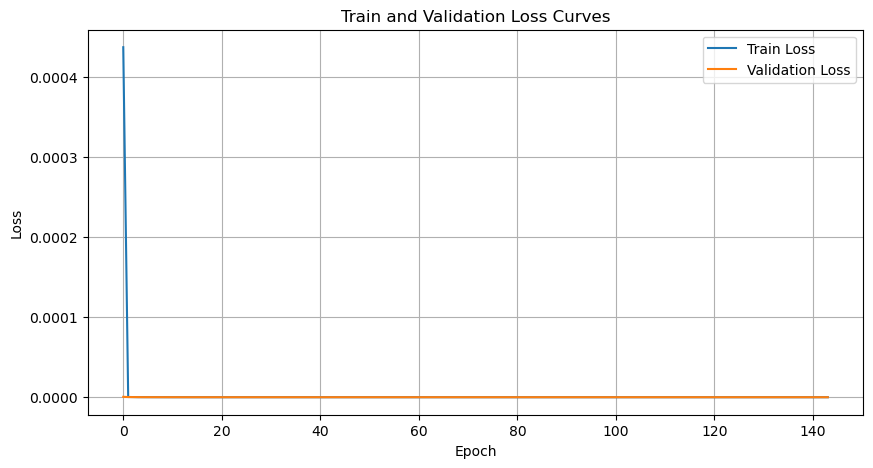

Explained variance ratio: 0.99999934


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Create PyTorch datasets and dataloaders
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            # nn.Dropout(0.2),  # 添加 Dropout
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            # nn.Dropout(0.2),  # 添加 Dropout
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed + x # residual connection

input_dim = X_train.shape[1]
latent_dim = 5  # Reduce to 5 dimensions

model = Autoencoder(input_dim, latent_dim)

# Step 3: Train the autoencoder
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)  

num_epochs = 2000
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, _ in val_loader:
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.item() * batch_features.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, Learning Rate: {current_lr:.7f}')

    # 检查 Early Stopping 条件
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # 重置计数器
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Extract the latent features
model.eval()
with torch.no_grad():
    # Transform the entire dataset
    X_latent = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

# The variable X_latent now contains the 5-dimensional representation of your data
# You can convert it back to a DataFrame if needed
latent_df_resautoencoder = pd.DataFrame(X_latent, columns=[f'Factor_{i+1}' for i in range(latent_dim)])

model.eval()
with torch.no_grad():
    reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32))
    reconstruction_errors = torch.mean((torch.tensor(X_scaled, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

total_variance = np.var(X_scaled, axis=0).sum()

# 计算每个因子贡献的方差
# 通过重建数据的方差贡献，计算解释率
reconstruction_variance = np.var(reconstructed.numpy(), axis=0).sum()

# 计算方差解释率
explained_variance_ratio = reconstruction_variance / total_variance
print(f"Explained variance ratio: {explained_variance_ratio:.8f}")

In [12]:
total_variance

4.571735520111981

In [22]:
from sklearn.metrics import explained_variance_score
model.eval()

# 关闭梯度计算
with torch.no_grad():
    # 模型的重构输出
    reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

# 使用 sklearn 的 explained_variance_score 计算解释方差
explained_variance = explained_variance_score(X_scaled, reconstructed, multioutput='uniform_average')

print(f"Explained Variance Score: {explained_variance:.8f}")

Explained Variance Score: 0.99999998


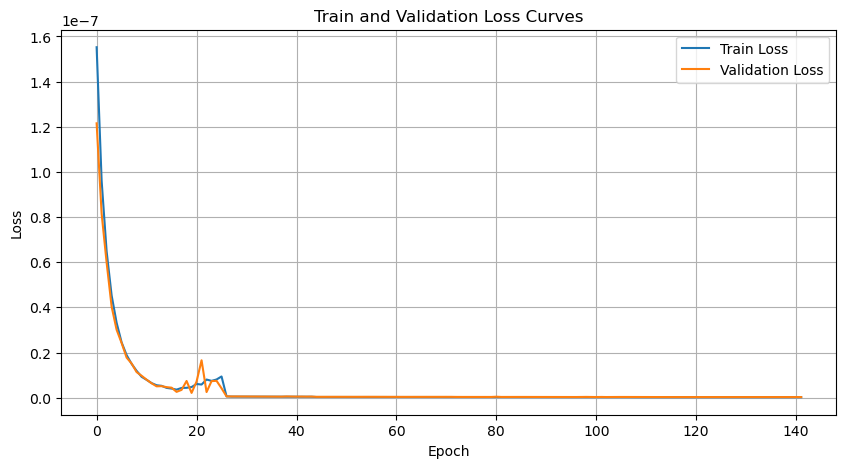

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses[2:], label='Train Loss')
plt.plot(val_losses[2:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


# 将 latent_df 转换为 numpy 数组（如果它是 Pandas DataFrame）
latent_factors = latent_df.values if isinstance(latent_df, pd.DataFrame) else latent_df
original_features = X if isinstance(X, np.ndarray) else X.values

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]

loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df_99 = pd.DataFrame(loadings, columns=[f'Latent_{j+1}' for j in range(n_latent_factors)])
loadings_df_99.index = [f'Feature_{i+1}' for i in range(n_original_features)]

# 输出每个潜在因子对原始特征的贡献（类似于 PCA 的负载）
print(loadings_df_99)
loadings_df_99.index = qns.iloc[:,2:].columns



             Latent_1  Latent_2  Latent_3  Latent_4  Latent_5
Feature_1    0.110823  0.460510 -0.074807  0.093272  0.153237
Feature_2    0.367635  0.205228  0.129734 -0.497270  0.677913
Feature_3    0.155277  0.815104 -0.135742  0.090663  0.180331
Feature_4    0.051107  0.150890  0.023923  0.067021  0.176713
Feature_5    0.010065  0.030223 -0.004261  0.013842  0.025266
...               ...       ...       ...       ...       ...
Feature_110  0.062615  0.111872 -0.035269  0.004190  0.035060
Feature_111  0.116064  0.217362  0.260819 -0.082667  0.391066
Feature_112  0.000625  0.011500  0.002888  0.011653  0.008465
Feature_113  0.001006  0.124137  0.033902  0.135935  0.151566
Feature_114 -0.226566  0.297837  0.648427  0.283402  0.369720

[114 rows x 5 columns]


In [28]:
df99 = pd.DataFrame()
for i in range(5):
    df0 = loadings_df_99['Latent_{0}'.format(i+1)].reindex(
        loadings_df_99['Latent_{0}'.format(i+1)].abs().sort_values(ascending=False).index
    ).to_frame(name='Latent_{0}'.format(i+1))
    df0 = df0.reset_index().rename(columns={'index': 'Row_Name'})
    df99 = pd.concat([df99, df0], axis=1)
df_even_columns99 = df99.iloc[:, ::2]  # 选择所有行和每隔两列的列
df_even_columns99

,Row_Name,Row_Name,Row_Name,Row_Name,Row_Name
0,cbcl_q55_p,cbcl_q78_p,cbcl_q44_p,cbcl_q44_p,cbcl_q03_p
1,cbcl_q53_p,cbcl_q08_p,cbcl_q112_p,cbcl_q03_p,cbcl_q86_p
2,cbcl_q03_p,cbcl_q10_p,cbcl_q71_p,cbcl_q55_p,cbcl_q95_p
3,cbcl_q32_p,cbcl_q04_p,cbcl_q56f_p,cbcl_q22_p,cbcl_q22_p
4,cbcl_q22_p,cbcl_q17_p,cbcl_q32_p,cbcl_q71_p,cbcl_q27_p
...,...,...,...,...,...
109,cbcl_q18_p,cbcl_q96_p,cbcl_q96_p,cbcl_q15_p,cbcl_q17_p
110,cbcl_q13_p,cbcl_q18_p,cbcl_q06_p,cbcl_q98_p,cbcl_q98_p
111,cbcl_q51_p,cbcl_q72_p,cbcl_q110_p,cbcl_q72_p,cbcl_q59_p
112,cbcl_q111_p,cbcl_q67_p,cbcl_q40_p,cbcl_q18_p,cbcl_q110_p


In [31]:
from utils import translate_text
from utils import get_cbcl_details
# get_cbcl_details(loadings_df)
details_autoencoder99 = translate_text(df_even_columns99, 5)

详细信息: Can't concentrate, can't pay attention for long No puede concentrarse o prestar atención por mucho tiempo; Can't sit still, restless, or hyperactive No puede quedarse quieto(a); es inquieto(a) o hiperactivo(a); Inattentive or easily distracted No presta atención o se distrae fácilmente


In [32]:
details_autoencoder99

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail
0,Overweight Tiene sobrepeso,超重就是超重,Inattentive or easily distracted No presta ate...,注意力不集中或容易分心 注意力不集中或容易分心,Bites fingernails Se come/muerde las uñas,咬指甲 咬指甲,Bites fingernails Se come/muerde las uñas,咬指甲 咬指甲,Argues a lot Discute mucho,争论很多 争论很多
1,Overeating Come demasiado,暴饮暴食 吃得太多,"Can't concentrate, can't pay attention for lon...",无法集中注意力，无法长时间集中注意力,Worries Se preocupa mucho,担心 他非常担心,Argues a lot Discute mucho,争论很多 争论很多,"Stubborn, sullen, or irritable Obstinado(a), m...",固执、闷闷不乐或易怒
2,Argues a lot Discute mucho,争论很多 争论很多,"Can't sit still, restless, or hyperactive No p...",无法静坐、焦躁或多动焦躁不安或过度活跃,Self-conscious or easily embarrassed Se cohíbe...,自我意识或容易感到尴尬,Overweight Tiene sobrepeso,超重就是超重,Temper tantrums or hot temper Le dan rabietas ...,发脾气或脾气暴躁 他发脾气或脾气不好
3,Feels they have to be perfect,感觉自己必须完美,Fails to finish things they start,无法完成他们开始的事情,Stomachaches Dolores de estómago,胃痛 胃痛,Disobedient at home Desobedece en casa,在家不听话,Disobedient at home Desobedece en casa,在家不听话
4,Disobedient at home Desobedece en casa,在家不听话,Daydreams or gets lost in their thoughts,做白日梦或陷入沉思,Feels they have to be perfect,感觉自己必须完美,Self-conscious or easily embarrassed Se cohíbe...,自我意识或容易感到尴尬,Easily jealous Se pone celoso(a) facilmente,容易嫉妒
...,...,...,...,...,...,...,...,...,...,...
109,Deliberately harms self or attempts suicide Se...,故意伤害自己或企图自杀\n 自杀,Thinks about sex too much Parece pensar demasi...,对性想太多 似乎对性问题想太多,Thinks about sex too much Parece pensar demasi...,对性想太多 似乎对性问题想太多,Cruel to animals Es cruel con los animales,对动物残忍,Daydreams or gets lost in their thoughts,做白日梦或陷入沉思
110,Confused or seems to be in a fog Está confundi...,感到困惑或似乎陷入迷雾,Deliberately harms self or attempts suicide Se...,故意伤害自己或企图自杀\n 自杀,Bowel movements outside toilet Hace sus necesi...,在厕所外排便 他在衣服上或在不适当的地方大小便,Thumb-sucking Se chupa el dedo,吮吸拇指,Thumb-sucking Se chupa el dedo,吮吸拇指
111,Feels dizzy or lightheaded Se siente mareado(a),感觉头晕或头晕,Sets fires Prende fuegos/inicia incendios,点火 点火/点火,Wishes to be of opposite sex Desea ser del sex...,希望成为异性,Sets fires Prende fuegos/inicia incendios,点火 点火/点火,Plays with own sex parts in public Se toca/jue...,在公共场合玩弄自己的性器官
112,"Withdrawn, doesn't get involved with others Se...",性格孤僻，不与他人交往,Runs away from home Se fuga de la casa,离家出走,Hears sound or voices that aren't there Oye so...,听到不存在的声音或声音,Deliberately harms self or attempts suicide Se...,故意伤害自己或企图自杀\n 自杀,Wishes to be of opposite sex Desea ser del sex...,希望成为异性


In [8]:
latent_df_resautoencoder

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.027374,0.122247,-0.145077,-0.171907,0.087387
1,0.027243,0.122044,-0.145116,-0.171879,0.087407
2,0.027051,0.121596,-0.145276,-0.171909,0.087324
3,0.026589,0.120428,-0.145707,-0.171367,0.087440
4,0.027126,0.121904,-0.145129,-0.172436,0.087160
...,...,...,...,...,...
10647,0.026829,0.121118,-0.145429,-0.171913,0.087276
10648,0.027090,0.121543,-0.145319,-0.172040,0.087268
10649,0.026885,0.120874,-0.145561,-0.171055,0.087700
10650,0.027623,0.122316,-0.145110,-0.171790,0.087249


## original model without residual connection

c:\Anaconda\envs\mne\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/2000], Train Loss: 0.034309099333, Val Loss: 0.030422418164, Learning Rate: 0.0010000
Epoch [2/2000], Train Loss: 0.028501524629, Val Loss: 0.028037369162, Learning Rate: 0.0010000
Epoch [3/2000], Train Loss: 0.027232707281, Val Loss: 0.027418039718, Learning Rate: 0.0010000
Epoch [4/2000], Train Loss: 0.026741243428, Val Loss: 0.026954768918, Learning Rate: 0.0010000
Epoch [5/2000], Train Loss: 0.026392150277, Val Loss: 0.026678847906, Learning Rate: 0.0010000
Epoch [6/2000], Train Loss: 0.026094182382, Val Loss: 0.026422403375, Learning Rate: 0.0010000
Epoch [7/2000], Train Loss: 0.025895755901, Val Loss: 0.026291729860, Learning Rate: 0.0010000
Epoch [8/2000], Train Loss: 0.025721893194, Val Loss: 0.026245825834, Learning Rate: 0.0010000
Epoch [9/2000], Train Loss: 0.025612569837, Val Loss: 0.026097968665, Learning Rate: 0.0010000
Epoch [10/2000], Train Loss: 0.025507670135, Val Loss: 0.026083735662, Learning Rate: 0.0010000
Epoch [11/2000], Train Loss: 0.025399517558, Val 

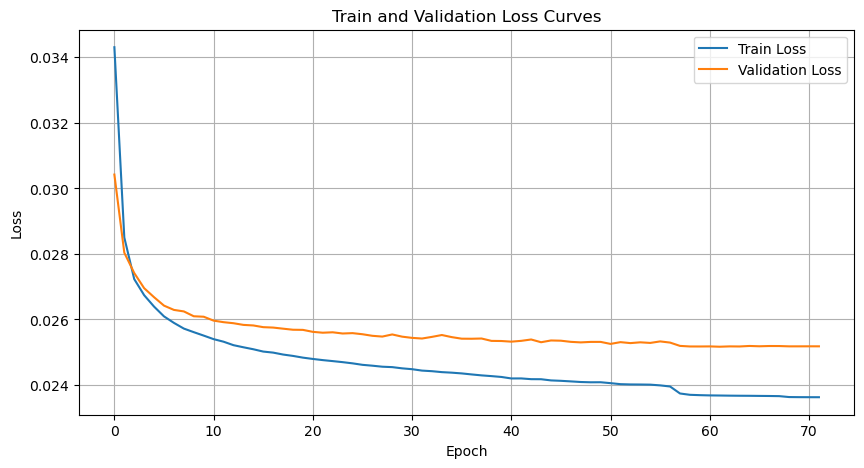

Explained variance ratio: 0.40561399


In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Create PyTorch datasets and dataloaders
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            # nn.Dropout(0.2),  # 添加 Dropout
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            # nn.Dropout(0.2),  # 添加 Dropout
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = X_train.shape[1]
latent_dim = 5  # Reduce to 5 dimensions

model = Autoencoder(input_dim, latent_dim)

# Step 3: Train the autoencoder
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)  

num_epochs = 2000
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, _ in val_loader:
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.item() * batch_features.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, Learning Rate: {current_lr:.7f}')

    # 检查 Early Stopping 条件
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # 重置计数器
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Extract the latent features
model.eval()
with torch.no_grad():
    # Transform the entire dataset
    X_latent = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

# The variable X_latent now contains the 5-dimensional representation of your data
# You can convert it back to a DataFrame if needed
latent_df = pd.DataFrame(X_latent, columns=[f'Factor_{i+1}' for i in range(latent_dim)])

model.eval()
with torch.no_grad():
    reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32))
    reconstruction_errors = torch.mean((torch.tensor(X_scaled, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

total_variance = np.var(X_scaled, axis=0).sum()

# 计算每个因子贡献的方差
# 通过重建数据的方差贡献，计算解释率
reconstruction_variance = np.var(reconstructed.numpy(), axis=0).sum()

# 计算方差解释率
explained_variance_ratio = reconstruction_variance / total_variance
print(f"Explained variance ratio: {explained_variance_ratio:.8f}")

In [6]:
latent_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,-0.388386,0.045050,-0.204790,0.358138,-0.016968
1,-0.702391,-0.094938,-0.165337,0.047190,0.052774
2,0.202194,0.408684,0.670443,0.349079,0.142731
3,-0.695568,0.739854,0.162883,-0.249876,0.182804
4,-0.465596,0.721330,-0.588197,-0.901318,1.331056
...,...,...,...,...,...
10647,0.375490,0.677997,0.414221,0.671053,1.042907
10648,-0.343688,-0.018049,-0.207315,-0.356148,0.898536
10649,-0.365368,0.011825,-0.013713,0.181165,-0.040213
10650,-0.516104,-0.171924,0.150925,-0.025770,0.834493


## interpretability

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


# 将 latent_df 转换为 numpy 数组（如果它是 Pandas DataFrame）
latent_factors = latent_df.values if isinstance(latent_df, pd.DataFrame) else latent_df
original_features = X if isinstance(X, np.ndarray) else X.values

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]

loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df = pd.DataFrame(loadings, columns=[f'Latent_{j+1}' for j in range(n_latent_factors)])
loadings_df.index = [f'Feature_{i+1}' for i in range(n_original_features)]

# 输出每个潜在因子对原始特征的贡献（类似于 PCA 的负载）
print(loadings_df)


             Latent_1  Latent_2  Latent_3  Latent_4  Latent_5
Feature_1    0.036440 -0.339702  0.222011  0.153030 -0.217333
Feature_2    0.630918 -0.137170 -0.315881  0.362826 -0.547442
Feature_3    0.080026 -0.561733  0.386453  0.211218 -0.419661
Feature_4    0.036017 -0.167850  0.079361  0.226327 -0.028242
Feature_5    0.003873 -0.032829  0.024694  0.023678 -0.011694
...               ...       ...       ...       ...       ...
Feature_110  0.051785 -0.080088  0.089053  0.023258 -0.032682
Feature_111  0.142151 -0.219396 -0.149780  0.406722 -0.301502
Feature_112 -0.005073 -0.013781  0.008267  0.016113  0.001419
Feature_113 -0.060729 -0.182824  0.118298  0.243093  0.012986
Feature_114 -0.424348 -0.427194 -0.199977  0.800109 -0.305814

[114 rows x 5 columns]


In [231]:
loadings_df

,Latent_1,Latent_2,Latent_3,Latent_4,Latent_5
Feature_1,0.036440,-0.339702,0.222011,0.153030,-0.217333
Feature_2,0.630918,-0.137170,-0.315881,0.362826,-0.547442
Feature_3,0.080026,-0.561733,0.386453,0.211218,-0.419661
Feature_4,0.036017,-0.167850,0.079361,0.226327,-0.028242
Feature_5,0.003873,-0.032829,0.024694,0.023678,-0.011694
...,...,...,...,...,...
Feature_110,0.051785,-0.080088,0.089053,0.023258,-0.032682
Feature_111,0.142151,-0.219396,-0.149780,0.406722,-0.301502
Feature_112,-0.005073,-0.013781,0.008267,0.016113,0.001419
Feature_113,-0.060729,-0.182824,0.118298,0.243093,0.012986


In [234]:
loadings_df.index = qns.iloc[:,2:].columns

In [235]:
loadings_df

,Latent_1,Latent_2,Latent_3,Latent_4,Latent_5
cbcl_q01_p,0.036440,-0.339702,0.222011,0.153030,-0.217333
cbcl_q03_p,0.630918,-0.137170,-0.315881,0.362826,-0.547442
cbcl_q04_p,0.080026,-0.561733,0.386453,0.211218,-0.419661
cbcl_q05_p,0.036017,-0.167850,0.079361,0.226327,-0.028242
cbcl_q06_p,0.003873,-0.032829,0.024694,0.023678,-0.011694
...,...,...,...,...,...
cbcl_q108_p,0.051785,-0.080088,0.089053,0.023258,-0.032682
cbcl_q109_p,0.142151,-0.219396,-0.149780,0.406722,-0.301502
cbcl_q110_p,-0.005073,-0.013781,0.008267,0.016113,0.001419
cbcl_q111_p,-0.060729,-0.182824,0.118298,0.243093,0.012986


In [236]:
df = pd.DataFrame()
for i in range(5):
    df0 = loadings_df['Latent_{0}'.format(i+1)].reindex(
        loadings_df['Latent_{0}'.format(i+1)].abs().sort_values(ascending=False).index
    ).to_frame(name='Latent_{0}'.format(i+1))
    df0 = df0.reset_index().rename(columns={'index': 'Row_Name'})
    df = pd.concat([df, df0], axis=1)


In [237]:
df# 假设 df 是你的 DataFrame
df_even_columns = df.iloc[:, ::2]  # 选择所有行和每隔两列的列
df_even_columns

,Row_Name,Row_Name,Row_Name,Row_Name,Row_Name
0,cbcl_q03_p,cbcl_q78_p,cbcl_q08_p,cbcl_q71_p,cbcl_q10_p
1,cbcl_q22_p,cbcl_q08_p,cbcl_q78_p,cbcl_q112_p,cbcl_q78_p
2,cbcl_q28_p,cbcl_q44_p,cbcl_q44_p,cbcl_q32_p,cbcl_q08_p
3,cbcl_q95_p,cbcl_q71_p,cbcl_q04_p,cbcl_q50_p,cbcl_q55_p
4,cbcl_q43_p,cbcl_q04_p,cbcl_q55_p,cbcl_q75_p,cbcl_q03_p
...,...,...,...,...,...
109,cbcl_q85_p,cbcl_q59_p,cbcl_q59_p,cbcl_q67_p,cbcl_q72_p
110,cbcl_q66_p,cbcl_q96_p,cbcl_q90_p,cbcl_q110_p,cbcl_q56c_p
111,cbcl_q103_p,cbcl_q67_p,cbcl_q67_p,cbcl_q60_p,cbcl_q56a_p
112,cbcl_q40_p,cbcl_q15_p,cbcl_q18_p,cbcl_q59_p,cbcl_q110_p


In [238]:
from utils import translate_text
from utils import get_cbcl_details
# get_cbcl_details(loadings_df)
details_autoencoder = translate_text(df_even_columns, 5)

In [239]:
details_autoencoder

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail
0,Argues a lot Discute mucho,争论很多 争论很多,Inattentive or easily distracted No presta ate...,注意力不集中或容易分心 注意力不集中或容易分心,"Can't concentrate, can't pay attention for lon...",无法集中注意力，无法长时间集中注意力,Self-conscious or easily embarrassed Se cohíbe...,自我意识或容易感到尴尬,"Can't sit still, restless, or hyperactive No p...",无法静坐、焦躁或多动焦躁不安或过度活跃
1,Disobedient at home Desobedece en casa,在家不听话,"Can't concentrate, can't pay attention for lon...",无法集中注意力，无法长时间集中注意力,Inattentive or easily distracted No presta ate...,注意力不集中或容易分心 注意力不集中或容易分心,Worries Se preocupa mucho,担心 他非常担心,Inattentive or easily distracted No presta ate...,注意力不集中或容易分心 注意力不集中或容易分心
2,"Breaks rules at home, school or elsewhere No r...",违反家庭、学校或其他地方的规则 不尊重/违反家庭、学校或其他地方的规则\n ...,Bites fingernails Se come/muerde las uñas,咬指甲 咬指甲,Bites fingernails Se come/muerde las uñas,咬指甲 咬指甲,Feels they have to be perfect,感觉自己必须完美,"Can't concentrate, can't pay attention for lon...",无法集中注意力，无法长时间集中注意力
3,Temper tantrums or hot temper Le dan rabietas ...,发脾气或脾气暴躁 他发脾气或脾气不好,Self-conscious or easily embarrassed Se cohíbe...,自我意识或容易感到尴尬,Fails to finish things they start,无法完成他们开始的事情,Too fearful or anxious Demasiado ansioso(a) o ...,过于恐惧或焦虑,Overweight Tiene sobrepeso,超重就是超重
4,Lying or cheating Dice mentiras o hace trampas,说谎或欺骗 谎言或欺骗,Fails to finish things they start,无法完成他们开始的事情,Overweight Tiene sobrepeso,超重就是超重,Too shy or timid Demasiado tímido(a),太害羞或胆怯,Argues a lot Discute mucho,争论很多 争论很多
...,...,...,...,...,...,...,...,...,...,...
109,Strange ideas Ideas raras,奇怪的想法 奇怪的想法,Plays with own sex parts in public Se toca/jue...,在公共场合玩弄自己的性器官,Plays with own sex parts in public Se toca/jue...,在公共场合玩弄自己的性器官,Runs away from home Se fuga de la casa,离家出走,Sets fires Prende fuegos/inicia incendios,点火 点火/点火
110,Repeats certain acts over and over; compulsion...,一遍又一遍地重复某些动作；强迫行为 一遍又一遍地重复某些动作；强迫症,Thinks about sex too much Parece pensar demasi...,对性想太多 似乎对性问题想太多,"Swearing or obscene language Dice groserías, u...",脏话或淫秽语言,Wishes to be of opposite sex Desea ser del sex...,希望成为异性,"Nausea, feels sick Náuseas, ganas de vomitar",恶心，感觉不舒服 恶心，想呕吐
111,"Unhappy, sad, or depressed Infeliz, triste, o ...",不快乐、悲伤或沮丧,Runs away from home Se fuga de la casa,离家出走,Runs away from home Se fuga de la casa,离家出走,Plays with own sex parts too much Se toca/jueg...,过多地玩弄自己的性器官,Aches or pains (not stomach or headaches) Dolo...,疼痛（不是胃痛或头痛）\n 头）
112,Hears sound or voices that aren't there Oye so...,听到不存在的声音或声音,Cruel to animals Es cruel con los animales,对动物残忍,Deliberately harms self or attempts suicide Se...,故意伤害自己或企图自杀\n 自杀,Plays with own sex parts in public Se toca/jue...,在公共场合玩弄自己的性器官,Wishes to be of opposite sex Desea ser del sex...,希望成为异性


In [207]:
label

,V1,V2,V3,V4,V5
0,1.751872e-02,2.220446e-16,2.649594e-02,1.741121e-01,2.196371e-02
1,2.486607e-01,2.220446e-16,4.967479e-02,2.220446e-16,2.379857e-01
2,8.817770e-02,3.270993e-02,4.842723e-03,3.130466e-01,4.470427e-02
3,2.220446e-16,2.220446e-16,5.115303e-02,2.220446e-16,2.914290e-02
4,2.184175e-02,2.220446e-16,2.220446e-16,2.220446e-16,2.259211e-03
...,...,...,...,...,...
109,1.446061e-01,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16
110,1.524203e-01,2.220446e-16,7.741409e-02,2.220446e-16,8.264507e-02
111,2.220446e-16,2.220446e-16,4.895438e-03,2.220446e-16,1.521318e-03
112,2.220446e-16,2.220446e-16,6.074961e-02,2.220446e-16,2.220446e-16


In [217]:
label.index = qns.iloc[:,2:].columns

In [218]:
df_NMF = pd.DataFrame()
for i in range(5):
    df0 = label['V{0}'.format(i+1)].reindex(
        label['V{0}'.format(i+1)].abs().sort_values(ascending=False).index
    ).to_frame(name='V{0}'.format(i+1))
    df0 = df0.reset_index().rename(columns={'index': 'Row_Name{0}'.format(i+1)})
    df_NMF = pd.concat([df_NMF, df0], axis=1)
df_NMF

,Row_Name1,V1,Row_Name2,V2,Row_Name3,V3,Row_Name4,V4,Row_Name5,V5
0,cbcl_q44_p,5.292841e-01,cbcl_q56b_p,3.725984e-01,cbcl_q71_p,2.746149e-01,cbcl_q78_p,5.354638e-01,cbcl_q22_p,2.551298e-01
1,cbcl_q58_p,3.301261e-01,cbcl_q56f_p,3.039952e-01,cbcl_q112_p,2.687242e-01,cbcl_q08_p,4.821404e-01,cbcl_q28_p,2.449673e-01
2,cbcl_q03_p,2.486607e-01,cbcl_q56e_p,2.214641e-01,cbcl_q32_p,2.435169e-01,cbcl_q10_p,3.947233e-01,cbcl_q03_p,2.379857e-01
3,cbcl_q07_p,1.807600e-01,cbcl_q56a_p,2.106441e-01,cbcl_q50_p,2.128253e-01,cbcl_q04_p,3.130466e-01,cbcl_q95_p,1.962269e-01
4,cbcl_q22_p,1.701090e-01,cbcl_q55_p,2.029320e-01,cbcl_q75_p,1.979764e-01,cbcl_q17_p,2.911422e-01,cbcl_q43_p,1.862933e-01
...,...,...,...,...,...,...,...,...,...,...
109,cbcl_q41_p,2.220446e-16,cbcl_q15_p,2.220446e-16,cbcl_q22_p,2.220446e-16,cbcl_q49_p,2.220446e-16,cbcl_q58_p,2.220446e-16
110,cbcl_q40_p,2.220446e-16,cbcl_q50_p,2.220446e-16,cbcl_q72_p,2.220446e-16,cbcl_q44_p,2.220446e-16,cbcl_q62_p,2.220446e-16
111,cbcl_q39_p,2.220446e-16,cbcl_q16_p,2.220446e-16,cbcl_q43_p,2.220446e-16,cbcl_q40_p,2.220446e-16,cbcl_q71_p,2.220446e-16
112,cbcl_q38_p,2.220446e-16,cbcl_q48_p,2.220446e-16,cbcl_q21_p,2.220446e-16,cbcl_q39_p,2.220446e-16,cbcl_q75_p,2.220446e-16


In [223]:
df_NMF_even_columns = df_NMF.iloc[:, ::2]  # 选择所有行和每隔两列的列
df_NMF_even_columns

,Row_Name1,Row_Name2,Row_Name3,Row_Name4,Row_Name5
0,cbcl_q44_p,cbcl_q56b_p,cbcl_q71_p,cbcl_q78_p,cbcl_q22_p
1,cbcl_q58_p,cbcl_q56f_p,cbcl_q112_p,cbcl_q08_p,cbcl_q28_p
2,cbcl_q03_p,cbcl_q56e_p,cbcl_q32_p,cbcl_q10_p,cbcl_q03_p
3,cbcl_q07_p,cbcl_q56a_p,cbcl_q50_p,cbcl_q04_p,cbcl_q95_p
4,cbcl_q22_p,cbcl_q55_p,cbcl_q75_p,cbcl_q17_p,cbcl_q43_p
...,...,...,...,...,...
109,cbcl_q41_p,cbcl_q15_p,cbcl_q22_p,cbcl_q49_p,cbcl_q58_p
110,cbcl_q40_p,cbcl_q50_p,cbcl_q72_p,cbcl_q44_p,cbcl_q62_p
111,cbcl_q39_p,cbcl_q16_p,cbcl_q43_p,cbcl_q40_p,cbcl_q71_p
112,cbcl_q38_p,cbcl_q48_p,cbcl_q21_p,cbcl_q39_p,cbcl_q75_p


In [224]:
details = translate_text(df_NMF_even_columns, 5)

In [225]:
details

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail
0,Bites fingernails Se come/muerde las uñas,咬指甲 咬指甲,Headaches Dolores de cabeza,头痛 头痛,Self-conscious or easily embarrassed Se cohíbe...,自我意识或容易感到尴尬,Inattentive or easily distracted No presta ate...,注意力不集中或容易分心 注意力不集中或容易分心,Disobedient at home Desobedece en casa,在家不听话
1,"Picks nose, skin, or other parts of body Mete ...",抠鼻子、皮肤或身体其他部位\n 身体,Stomachaches Dolores de estómago,胃痛 胃痛,Worries Se preocupa mucho,担心 他非常担心,"Can't concentrate, can't pay attention for lon...",无法集中注意力，无法长时间集中注意力,"Breaks rules at home, school or elsewhere No r...",违反家庭、学校或其他地方的规则 不尊重/违反家庭、学校或其他地方的规则\n ...
2,Argues a lot Discute mucho,争论很多 争论很多,Rashes or other skin problems Salpullido o irr...,皮疹或其他皮肤问题,Feels they have to be perfect,感觉自己必须完美,"Can't sit still, restless, or hyperactive No p...",无法静坐、焦躁或多动焦躁不安或过度活跃,Argues a lot Discute mucho,争论很多 争论很多
3,"Bragging, boasting Es engreído(a), presumido(a)",吹牛、自夸,Aches or pains (not stomach or headaches) Dolo...,疼痛（不是胃痛或头痛）\n 头）,Too fearful or anxious Demasiado ansioso(a) o ...,过于恐惧或焦虑,Fails to finish things they start,无法完成他们开始的事情,Temper tantrums or hot temper Le dan rabietas ...,发脾气或脾气暴躁 他发脾气或脾气不好
4,Disobedient at home Desobedece en casa,在家不听话,Overweight Tiene sobrepeso,超重就是超重,Too shy or timid Demasiado tímido(a),太害羞或胆怯,Daydreams or gets lost in their thoughts,做白日梦或陷入沉思,Lying or cheating Dice mentiras o hace trampas,说谎或欺骗 谎言或欺骗
...,...,...,...,...,...,...,...,...,...,...
109,Impulsive or acts without thinking Impulsivo(a...,冲动或不假思索的冲动（a）；不假思索地行动,Cruel to animals Es cruel con los animales,对动物残忍,Disobedient at home Desobedece en casa,在家不听话,"Constipated, doesn't move bowels Padece de est...",便秘，拉不动大便,"Picks nose, skin, or other parts of body Mete ...",抠鼻子、皮肤或身体其他部位\n 身体
110,Hears sound or voices that aren't there Oye so...,听到不存在的声音或声音,Too fearful or anxious Demasiado ansioso(a) o ...,过于恐惧或焦虑,Sets fires Prende fuegos/inicia incendios,点火 点火/点火,Bites fingernails Se come/muerde las uñas,咬指甲 咬指甲,Poorly coordinated or clumsy Mala coordinación...,协调性差或笨拙
111,Hangs around with others who get in trouble Se...,与遇到麻烦的人在一起,"Cruelty, bullying, or meanness to others Es cr...",对他人残忍、欺凌或卑鄙,Lying or cheating Dice mentiras o hace trampas,说谎或欺骗 谎言或欺骗,Hears sound or voices that aren't there Oye so...,听到不存在的声音或声音,Self-conscious or easily embarrassed Se cohíbe...,自我意识或容易感到尴尬
112,Gets teased a lot Los demás se burlan de él/el...,经常被取笑其他人经常取笑他/她,Not liked by other kids No le cae bien a otros...,不被其他孩子喜欢,Destroys things belonging to their family or o...,毁坏属于家人或他人的物品,Hangs around with others who get in trouble Se...,与遇到麻烦的人在一起,Too shy or timid Demasiado tímido(a),太害羞或胆怯


## lasso regression model from questionnaire items to factors generated with NMF

100%|██████████| 13/13 [00:22<00:00,  1.76s/it]
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_1080\1593782529.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(alpha_values)


Text(83.22222222222221, 0.5, 'Factor')

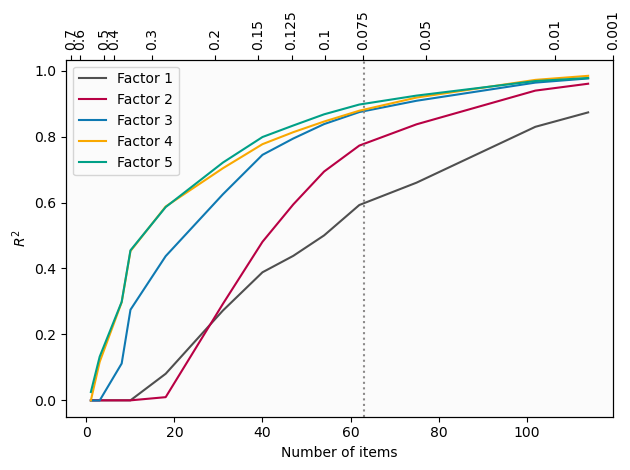

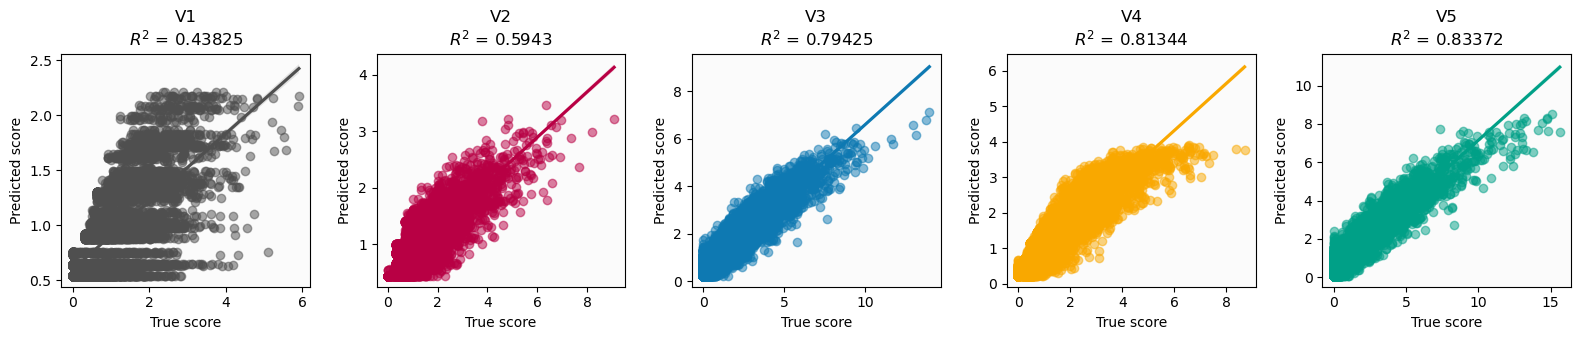

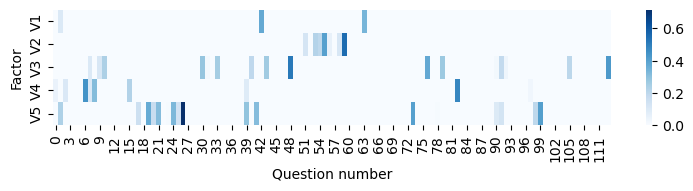

In [132]:
# LAsso
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import scale
import seaborn as sns
from scipy.stats.distributions import halfcauchy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm
import joblib
import os
import matplotlib
import matplotlib.font_manager as font_manager
#import svr
from sklearn.svm import SVR
#import lasso
from sklearn.linear_model import Lasso
#import MLP Regressor
from sklearn.neural_network import MLPRegressor
qns = X
scores = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\NMF_W.csv').iloc[:,2:]

clf = MLPRegressor()
alpha_values = [0.001, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
r2_values = np.empty((5, len(alpha_values)))
n_items = np.empty(len(alpha_values))

for n, alpha in enumerate(tqdm(alpha_values)):
    clf = Lasso(alpha=alpha)
    clf.fit(qns, scores)
    pred = cross_val_predict(clf, qns, scores, cv=5)
    for i in range(5):
        r2_values[i, n] = r2_score(scores.iloc[:, i], pred[:, i])
    n_items[n] = np.any(clf.coef_.T != 0, axis=1).sum()
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
# matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#4f4f4f', '#B80044', '#0e79b2', '#f9a800', '#00a087']
f, ax = plt.subplots(dpi=100, facecolor='white')
for i in range(5):
    ax.plot(n_items, r2_values[i, :], label='Factor {0}'.format(i+1), color=pal[i])
ax.set_xlabel("Number of items")
ax.set_ylabel("$R^2$")
ax.legend()
ax2 = ax.twiny()
ax2.set_xticklabels(alpha_values)
ax2.set_xticks(n_items)
ax.axvline(63, color='#8c8a8a', linestyle=':')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()

# plt.savefig('../figures/number_of_questions.svg')
clf = Lasso(alpha=0.125)
pred = cross_val_predict(clf, qns, scores, cv=5)
clf.fit(qns, scores);
f, ax = plt.subplots(1, 5, figsize=(16, 3.5), dpi=100, facecolor='white')

factors = ['V1', 'V2', 'V3','V4' ,'V5']

for i in range(5):
    sns.regplot(x = scores.iloc[:, i], y =  pred[:, i], ax=ax[i], color=pal[i], scatter_kws={'alpha': 0.5})
    ax[i].set_title(factors[i] + '\n$R^2$ = {0}'.format(np.round(r2_score(scores.iloc[:, i], pred[:, i]), 5)), fontweight='light')
    ax[i].set_xlabel('True score')
    ax[i].set_ylabel('Predicted score')
    
plt.tight_layout()
# plt.savefig('../figures/factor_prediction.svg')
plt.figure(dpi=100, figsize=(9, 1.5), facecolor='white')
sns.heatmap(clf.coef_, cmap='Blues', yticklabels=['V1', 'V2', 'V3', 'V4', 'V5'])
plt.xlabel("Question number")
plt.ylabel("Factor")
# plt.savefig('../figures/all_question_coefs.svg')

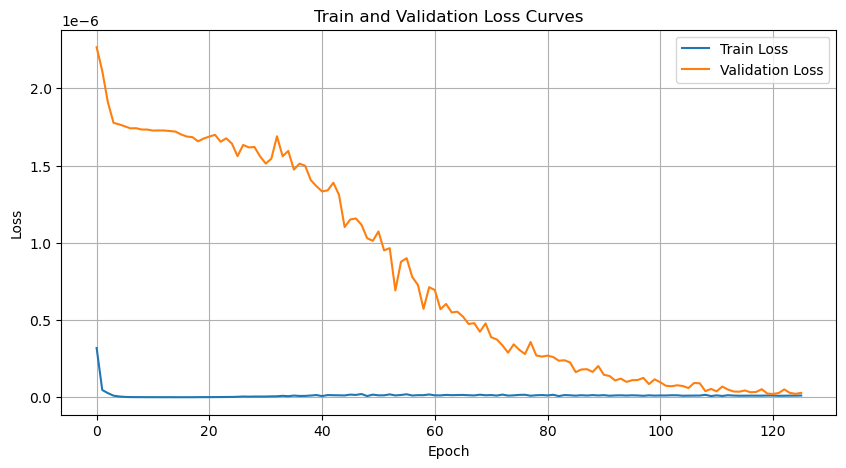

In [94]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


## draw the reconstuction error of the autoencoder model

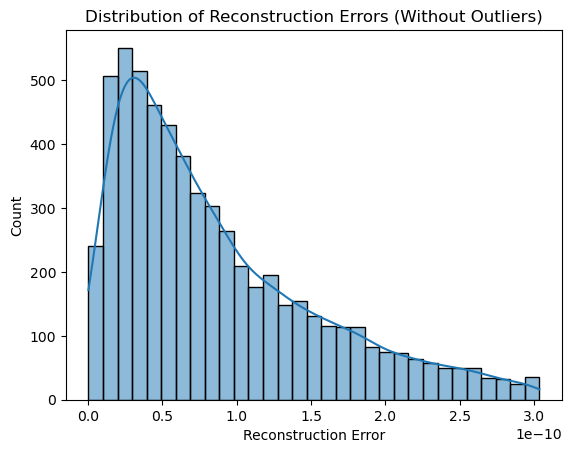

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    # 计算验证集的重构误差
    reconstructed = model(torch.tensor(X_train, dtype=torch.float32))
    reconstruction_errors = torch.mean((torch.tensor(X_train, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

# 计算四分位数
q1 = np.percentile(reconstruction_errors, 25)
q3 = np.percentile(reconstruction_errors, 75)
iqr = q3 - q1

# 定义一个范围，通常选择 1.5 倍的 IQR 来识别离群点
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# 过滤掉离群点
filtered_errors = reconstruction_errors[(reconstruction_errors >= lower_bound) & (reconstruction_errors <= upper_bound)]

# 绘制重构误差的分布
sns.histplot(filtered_errors, kde=True)
plt.xlabel('Reconstruction Error')
plt.title('Distribution of Reconstruction Errors (Without Outliers)')
plt.show()


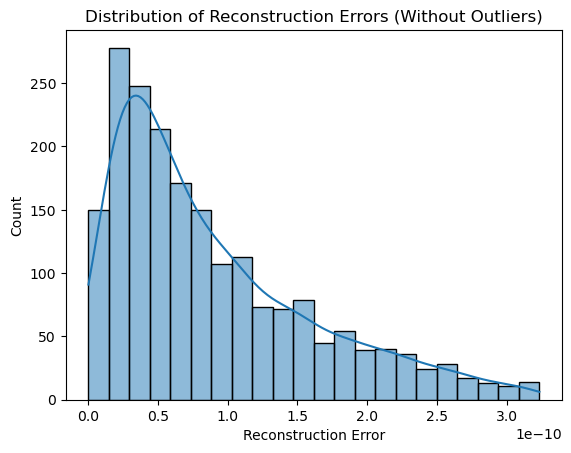

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    # 计算验证集的重构误差
    reconstructed = model(torch.tensor(X_val, dtype=torch.float32))
    reconstruction_errors = torch.mean((torch.tensor(X_val, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

# 计算四分位数
q1 = np.percentile(reconstruction_errors, 25)
q3 = np.percentile(reconstruction_errors, 75)
iqr = q3 - q1

# 定义一个范围，通常选择 1.5 倍的 IQR 来识别离群点
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# 过滤掉离群点
filtered_errors = reconstruction_errors[(reconstruction_errors >= lower_bound) & (reconstruction_errors <= upper_bound)]

# 绘制重构误差的分布
sns.histplot(filtered_errors, kde=True)
plt.xlabel('Reconstruction Error')
plt.title('Distribution of Reconstruction Errors (Without Outliers)')
plt.show()


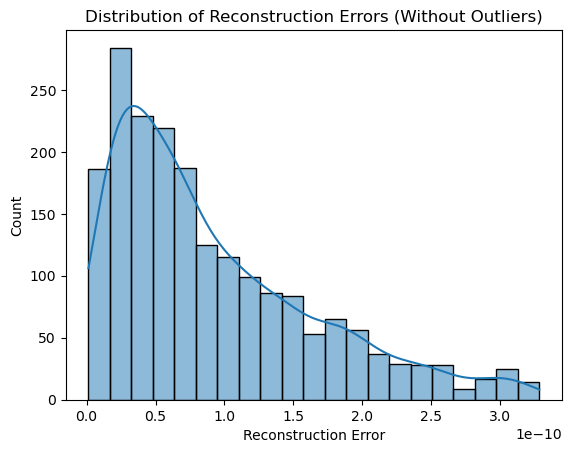

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    # 计算验证集的重构误差
    reconstructed = model(torch.tensor(X_test, dtype=torch.float32))
    reconstruction_errors = torch.mean((torch.tensor(X_test, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

# 计算四分位数
q1 = np.percentile(reconstruction_errors, 25)
q3 = np.percentile(reconstruction_errors, 75)
iqr = q3 - q1

# 定义一个范围，通常选择 1.5 倍的 IQR 来识别离群点
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# 过滤掉离群点
filtered_errors = reconstruction_errors[(reconstruction_errors >= lower_bound) & (reconstruction_errors <= upper_bound)]

# 绘制重构误差的分布
sns.histplot(filtered_errors, kde=True)
plt.xlabel('Reconstruction Error')
plt.title('Distribution of Reconstruction Errors (Without Outliers)')
plt.show()


## compare with EFA

In [32]:
from factor_analyzer import FactorAnalyzer

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=5, rotation='varimax')
fa.fit(qns.iloc[:,2:])
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev
factor_loadings = fa.loadings_
# 计算每个因子的贡献方差和方差解释率
variance_explained = fa.get_factor_variance()
print(f"varience explained: {variance_explained[2][-1]:.2%}")

varience explained: 24.05%


# To be done: 

## Test autoencoder model with different number of latent_dim (different number of factors)

In [ ]:
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = X_train.shape[1]
# latent_dim = 5  # Reduce to 5 dimensions
latent_dims = range(2, 17)
val_losses = []
explained_variance_ratios = []
for latent_dim in latent_dims:
    model = Autoencoder(input_dim, latent_dim)

    # Step 3: Train the autoencoder
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 200
    patience = 10
    best_val_loss = float('inf')
    epochs_without_improvement = 0


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_features.size(0)
        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, _ in val_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_features)
                val_loss += loss.item() * batch_features.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        


        # 检查 Early Stopping 条件
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # 重置计数器
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32))
    mse = nn.MSELoss(reduction='none')
    reconstruction_error = mse(reconstructed, torch.tensor(X_scaled, dtype=torch.float32)).mean(dim=1).detach().numpy()
    print(f'Reconstruction Error: {reconstruction_error.mean()}')

    val_losses.append(val_loss)
    total_variance = np.var(X_scaled, axis=0).sum()
    # 计算每个因子贡献的方差
    # 通过重建数据的方差贡献，计算解释率
    reconstruction_variance = np.var(reconstructed.detach().numpy(), axis=0).sum()
    # 计算方差解释率
    explained_variance_ratio = reconstruction_variance / total_variance
    explained_variance_ratios.append(explained_variance_ratio)
plt.plot(latent_dims, val_losses, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Latent Dimensions')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.plot(latent_dims, explained_variance_ratios, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Varience Explained ratio')
plt.title('Varience Explained ratio vs. Number of Latent Dimensions')
plt.show()

## From neuroimaging data to latent factors

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# load data and drop the first column and the subject id
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_aseg.csv")
# only keep eventname = baseline_year_1_arm_1
data = data[data['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname']).dropna()

labels = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\EFA.csv').iloc[:, 1:]
# labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')
# # only keep the  column.('cbcl_scr_syn_anxdep_t')
# labels = labels[labels['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname'])
# labels = labels[['src_subject_id', 'cbcl_scr_syn_anxdep_t']].dropna()

# only keep the subjects that have labels
data = data[data['src_subject_id'].isin(labels["src_subject_id"])]
data = data.drop(columns=['src_subject_id'])

In [81]:
data

,rsfmri_cor_ngd_au_scs_aalh,rsfmri_cor_ngd_au_scs_aarh,rsfmri_cor_ngd_au_scs_aglh,rsfmri_cor_ngd_au_scs_agrh,rsfmri_cor_ngd_au_scs_bs,rsfmri_cor_ngd_au_scs_cdelh,rsfmri_cor_ngd_au_scs_cderh,rsfmri_cor_ngd_au_scs_crcxlh,rsfmri_cor_ngd_au_scs_crcxrh,rsfmri_cor_ngd_au_scs_hplh,...,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_pllh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_ptlh,rsfmri_cor_ngd_vs_scs_ptrh,rsfmri_cor_ngd_vs_scs_thplh,rsfmri_cor_ngd_vs_scs_thprh,rsfmri_cor_ngd_vs_scs_vtdclh,rsfmri_cor_ngd_vs_scs_vtdcrh
0,-0.090258,-0.083909,0.004247,-0.054861,-0.048167,0.036012,0.013843,-0.020096,-0.081816,-0.043832,...,0.106619,0.112692,0.013191,-0.106608,0.074385,0.119522,-0.135962,-0.060436,-0.000929,0.113327
1,-0.098593,0.093085,-0.170801,-0.134319,-0.022124,0.092985,0.061854,0.011913,0.013176,-0.010548,...,-0.026733,-0.061707,0.127464,-0.135847,0.097308,0.104559,-0.060583,-0.037027,0.021549,-0.014602
2,-0.065449,0.122893,-0.006246,-0.118878,-0.027118,-0.026523,-0.045971,-0.065351,-0.036497,-0.085342,...,0.076594,0.110142,-0.077766,-0.020942,0.120677,0.135012,0.020034,-0.017153,-0.043255,-0.072356
3,-0.148170,-0.049085,-0.026814,-0.028232,0.008625,-0.153769,-0.073198,-0.138927,0.032385,-0.063008,...,0.099686,0.077307,0.019302,0.064816,0.141727,0.010190,-0.038964,0.030539,-0.019395,-0.060836
6,-0.148117,0.037320,-0.104190,-0.037308,0.121178,0.034533,-0.183537,-0.258663,0.003149,-0.051349,...,-0.036267,-0.058694,-0.152607,-0.076361,0.058996,0.226045,-0.028446,-0.064175,-0.066788,0.010962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.030591,0.003116,-0.138875,-0.096117,-0.008607,-0.111538,-0.111535,-0.161508,-0.102951,-0.041270,...,0.097498,0.043633,0.055380,0.102299,0.149435,0.025411,-0.097254,0.030673,-0.084058,-0.002552
22120,-0.089590,-0.002218,-0.150480,0.052007,0.119924,-0.258660,-0.164504,-0.068733,-0.057475,-0.058599,...,0.016435,0.048579,0.084433,-0.091015,0.185989,0.038151,0.006236,0.012520,0.060238,-0.132834
22123,-0.112247,-0.010195,0.038551,-0.112359,-0.043313,0.045530,-0.188547,-0.048601,-0.165866,-0.003135,...,-0.023279,0.049299,0.093359,-0.069631,0.228659,0.213006,-0.077175,-0.049607,0.041590,-0.035196
22125,0.051633,-0.127992,-0.172488,0.013249,-0.014129,-0.236400,-0.056846,0.076282,-0.055248,-0.004072,...,0.062011,-0.025998,0.016382,-0.024677,0.084724,0.093898,0.000896,-0.202033,0.027023,0.074749


In [159]:
latent_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,-0.049463,-0.182340,0.196342,-0.021667,-0.165873
1,-0.073495,0.184756,0.475815,-0.223310,-0.065260
2,0.138151,0.586012,-0.170587,-0.674947,0.192490
3,0.007768,0.596885,-0.277861,-0.145240,-0.113471
4,-1.223910,-0.502999,-0.391843,-0.577163,0.860070
...,...,...,...,...,...
10647,-1.115234,1.064958,-0.486877,0.153948,-0.027026
10648,-0.762220,-0.169283,0.123275,-0.657285,0.165149
10649,-0.115862,-0.162614,0.316994,-0.069570,-0.044718
10650,-0.628295,0.264950,0.391845,-0.518549,-0.118380


In [158]:
latent_df.iloc[:,1]

0       -0.182340
1        0.184756
2        0.586012
3        0.596885
4       -0.502999
           ...   
10647    1.064958
10648   -0.169283
10649   -0.162614
10650    0.264950
10651   -0.121616
Name: Factor_2, Length: 10652, dtype: float32

In [ ]:
scores.iloc[:,1].to_numpy()

array([2.22044605e-16, 2.22044605e-16, 1.73553376e+00, ...,
       9.46933705e-05, 4.48807844e-01, 2.22044605e-16])

In [154]:
reshaped_array = scores.iloc[:,1].to_numpy().reshape(-1, 1)
reshaped_array

array([[2.22044605e-16],
       [2.22044605e-16],
       [1.73553376e+00],
       ...,
       [9.46933705e-05],
       [4.48807844e-01],
       [2.22044605e-16]])

In [155]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 假设 data 和 latent_df 已经有数据
X = data  # 原始数据
y = reshaped_array  # 目标是自编码器的低维表示

# Step 1: 数据准备
# 将数据分割为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 对 X 和 y 进行标准化
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Step 2: 创建数据集和数据加载器
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RegressionDataset(X_train_tensor, y_train_tensor)
val_dataset = RegressionDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 3: 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, input_dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, x):
        return x + self.block(x)

# Step 4: 定义 ResNet 风格的回归模型
class ResNetRegression(nn.Module):
    def __init__(self, input_dim, output_dim, num_blocks=3):
        super(ResNetRegression, self).__init__()
        self.input_layer = nn.Linear(input_dim, 64)
        self.hidden_layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.residual_blocks(x)
        x = self.output_layer(x)
        return x

input_dim = X.shape[1]  # 原始数据的特征数量
output_dim = y.shape[1]  # 自编码器的低维表示维度
model = ResNetRegression(input_dim, output_dim)

# Step 5: 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Step 6: 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # 验证模型
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Step 7: 模型评估
model.eval()
with torch.no_grad():
    # 使用验证集进行预测
    y_val_pred_scaled = model(X_val_tensor).numpy()

    # 将预测结果逆标准化
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_val_original = scaler_y.inverse_transform(y_val_scaled)

    # 计算均方误差和 R²
    mse = mean_squared_error(y_val_original, y_val_pred)
    r2 = r2_score(y_val_original, y_val_pred)

print(f"Mean Squared Error on Validation Set: {mse:.4f}")
print(f"R² Score on Validation Set: {r2:.4f}")


Epoch [1/100], Train Loss: 1.0137, Val Loss: 1.0495
Epoch [2/100], Train Loss: 0.9852, Val Loss: 1.0556
Epoch [3/100], Train Loss: 0.9586, Val Loss: 1.0508
Epoch [4/100], Train Loss: 0.9194, Val Loss: 1.0945
Epoch [5/100], Train Loss: 0.8684, Val Loss: 1.1168
Epoch [6/100], Train Loss: 0.8130, Val Loss: 1.1215
Epoch [7/100], Train Loss: 0.7375, Val Loss: 1.1793
Epoch [8/100], Train Loss: 0.6608, Val Loss: 1.1933
Epoch [9/100], Train Loss: 0.5818, Val Loss: 1.2376
Epoch [10/100], Train Loss: 0.5012, Val Loss: 1.2953
Epoch [11/100], Train Loss: 0.4463, Val Loss: 1.3203
Epoch [12/100], Train Loss: 0.4313, Val Loss: 1.2976
Epoch [13/100], Train Loss: 0.3558, Val Loss: 1.4215
Epoch [14/100], Train Loss: 0.3178, Val Loss: 1.3991
Epoch [15/100], Train Loss: 0.2813, Val Loss: 1.4148
Epoch [16/100], Train Loss: 0.2677, Val Loss: 1.4540
Epoch [17/100], Train Loss: 0.2510, Val Loss: 1.4939
Epoch [18/100], Train Loss: 0.2328, Val Loss: 1.5608
Epoch [19/100], Train Loss: 0.2069, Val Loss: 1.5500
Ep

KeyboardInterrupt: 

In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

def lasso_predict_r2(X, y, alpha=0.1, test_size=0.2, random_state=42):
    """
    使用 Lasso 从数据 X 预测目标 y，并返回 R² 分数。

    参数：
    - X: ndarray or DataFrame, 原始数据。
    - y: ndarray or DataFrame, 目标变量。
    - alpha: float, Lasso 模型的正则化强度。
    - test_size: float, 测试集所占比例。
    - random_state: int, 随机种子。

    返回：
    - r2: float, R² 分数。
    """
    # Step 1: 数据划分
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Step 2: 数据标准化
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Step 3: 训练 Lasso 模型
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train_scaled)

    # Step 4: 使用测试集进行预测并计算 R² 分数
    y_pred_scaled = lasso.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test_scaled)

    # 计算 R² 分数
    r2 = r2_score(y_test_original, y_pred)
    return r2

# 示例使用
# 假设 data 和 latent_df 是已加载的数据
r2 = lasso_predict_r2(data, latent_df)
print(f"R² Score: {r2:.4f}")


R² Score: -0.0001
